## Линейная регрессия

Будем рассматривать датасет для предсказания времени задержки отправления рейса в минутах (DepDelay).

### Подготовка данных

#### Пропуски

In [10]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',100)
%matplotlib inline

fly = pd.read_csv('2008.csv')


- Имеются ли пропущенные значения в целевой переменной?

In [11]:
fly = fly[fly['DepDelay'].notnull()]

In [14]:
fly = fly.drop(['Year','DepTime','ArrTime','AirTime','ArrDelay','ActualElapsedTime',\
 'TaxiIn','CancellationCode','TaxiOut',\
'Diverted','CarrierDelay','WeatherDelay','NASDelay',\
 'SecurityDelay','LateAircraftDelay'],axis=1)

In [17]:
fly.isnull().sum()

Month             0
DayofMonth        0
DayOfWeek         0
CRSDepTime        0
CRSArrTime        0
UniqueCarrier     0
FlightNum         0
TailNum           0
CRSElapsedTime    5
DepDelay          0
Origin            0
Dest              0
Distance          0
Cancelled         0
dtype: int64

In [21]:
CRSElapsedTime_median = fly['CRSElapsedTime'].median()
fly['CRSElapsedTime'] = fly['CRSElapsedTime'].fillna(CRSElapsedTime_median)

Некоторые из признаков, отличных от целевой переменной, могут оказывать чересчур значимое влияние на прогноз, поскольку по своему смыслу содержат большую долю информации о значении целевой переменной. Нужно исключить признаки, сильно коррелирующие с ответами.

In [24]:
fly.corr() # pyplot, seaborn

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,DepDelay,Distance,Cancelled
Month,1.000000,-0.004535,-0.011494,-0.005726,0.002835,0.006140,-0.004354,-0.027598,-0.004735,0.019147
DayofMonth,-0.004535,1.000000,0.014203,0.002298,0.001204,0.008866,-0.005953,0.008002,-0.005968,-0.003119
DayOfWeek,-0.011494,0.014203,1.000000,0.004856,0.005702,-0.006192,0.015399,0.008023,0.016653,0.000500
CRSDepTime,-0.005726,0.002298,0.004856,1.000000,0.790440,-0.011723,-0.009141,0.137659,-0.008915,0.005369
CRSArrTime,0.002835,0.001204,0.005702,0.790440,1.000000,-0.030084,0.060703,0.133053,0.050173,-0.000360
FlightNum,0.006140,0.008866,-0.006192,-0.011723,-0.030084,1.000000,-0.328349,0.015708,-0.349606,0.016410
CRSElapsedTime,-0.004354,-0.005953,0.015399,-0.009141,0.060703,-0.328349,1.000000,0.033906,0.983401,-0.007167
DepDelay,-0.027598,0.008002,0.008023,0.137659,0.133053,0.015708,0.033906,1.000000,0.024383,-0.000808
Distance,-0.004735,-0.005968,0.016653,-0.008915,0.050173,-0.349606,0.983401,0.024383,1.000000,-0.007604
Cancelled,0.019147,-0.003119,0.000500,0.005369,-0.000360,0.016410,-0.007167,-0.000808,-0.007604,1.000000


Приведем данные к виду, пригодному для обучения линейных моделей. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду

In [25]:
def scaler(column):
    mean = column.mean() # среднее
    std = column.std()# standart deviation, стандартное отклонение, сигма
    return (column - mean) / std
    
    
    

В первую очередь поймем, зачем необходимо применять масштабирование. Следующие ячейки с кодом построят гистограммы для 3 вещественных признаков выборки.

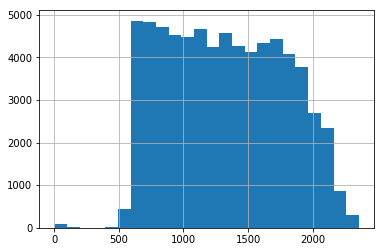

In [29]:
fly['CRSDepTime'].hist(bins=24) #(24 - per hour)

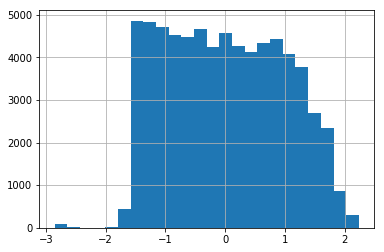

In [30]:
scaler(fly['CRSDepTime']).hist(bins=24)

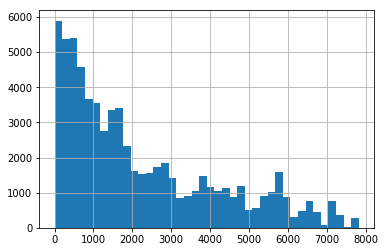

In [31]:
fly['FlightNum'].hist(bins=40) 

Некоторые из признаков являются категориальными. Типичным подходом к работе с ними является бинарное, или [one-hot-кодирование](https://en.wikipedia.org/wiki/One-hot).


In [44]:
fly = fly[fly['Cancelled'] == 0]

In [74]:
features_to_drop = ['TailNum','DayofMonth','Cancelled','DepDelay']

In [85]:
categorical_features = ['DayOfWeek','UniqueCarrier','FlightNum','Origin','Dest']## one-hot-encoding

In [76]:
num_features = ['CRSDepTime','CRSArrTime','CRSElapsedTime','Distance']

In [77]:
target = fly['DepDelay']

In [78]:
def one_hot(column, column_name):
    df = pd.DataFrame()
    unique_values = column.unique()
    for value in unique_values:
        df[column_name+'_'+str(value)] = (column == value).astype(int)
    return df

In [88]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
def create_df(X_,features_to_drop,categorical_features,num_features):
    X = X_.copy()
    for column in features_to_drop:
        del X[column]
        print(column)
    for column in categorical_features:
        le = preprocessing.LabelEncoder()
        X[column] = le.fit_transform(X[column])
    for column in num_features:
        X[column] = scaler(X[column])
        print(column)
    print(1)
    enc = OneHotEncoder(categorical_features=\
    [i for i, col in enumerate(X.columns) if col in categorical_features])
    X = enc.fit_transform(X)
    
    return X

In [89]:
X = create_df(fly,features_to_drop,categorical_features,num_features)

TailNum
DayofMonth
Cancelled
DepDelay
CRSDepTime
CRSArrTime
CRSElapsedTime
Distance
1


In [92]:
X

<68589x7603 sparse matrix of type '<class 'numpy.float64'>'
	with 685890 stored elements in COOrdinate format>

In [93]:
target

0        16.0
1        16.0
2        -2.0
3        -3.0
4        -5.0
5        24.0
6        -1.0
7        -5.0
8        -4.0
9        -2.0
10       42.0
12       11.0
13       -7.0
14       18.0
15       -9.0
16       -3.0
17        1.0
18       20.0
19       -1.0
20       -7.0
21       -3.0
22       -3.0
23       32.0
24       -4.0
25        1.0
26       -8.0
27       -1.0
28        0.0
29       -4.0
30       -7.0
         ... 
69970     2.0
69971    11.0
69972    10.0
69973    -3.0
69974    -1.0
69975    30.0
69976    -1.0
69977     5.0
69978    -5.0
69979    -7.0
69980    15.0
69981    34.0
69982    -9.0
69983    -4.0
69984   -10.0
69985    -3.0
69986    -4.0
69987    -8.0
69988    -1.0
69989    -2.0
69990    -3.0
69991    -6.0
69992    -7.0
69993    10.0
69994    -5.0
69995   -11.0
69996    24.0
69997     0.0
69998     6.0
69999    -1.0
Name: DepDelay, Length: 68589, dtype: float64

Разделим выборку и вектор целевой переменной на обучение и контроль в отношении 70/30 (для этого можно использовать, например, функцию [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html)). 

In [ ]:
X_train, X_test = X[X['Month'] < 11], X[X['Month'] >= 11]
target = fly['DepDelay']

### Scikit-learn

<img src = "https://pp.vk.me/c4534/u35727827/93547647/x_d31c4463.jpg">
Теперь, когда мы привели данные к пригодному виду, попробуем решить задачу при помощи метода наименьших квадратов. Напомним, что данный метод заключается в оптимизации функционала $MSE$:

$$MSE(X, y) = \frac{1}{l} \sum_{i=1}^l (<w, x_i> - y_i)^2 \to \min_{w},$$

где $\{ (x_i, y_i ) \}_{i=1}^l$ — обучающая выборка, состоящая из $l$ пар объект-ответ.

Решение данной задачи уже реализовано в модуле sklearn в виде класса [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).


In [96]:
import sklearn
from sklearn import linear_model#.LinearRegression

In [101]:
model = linear_model.LinearRegression()

In [102]:
model.fit(X,target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [106]:
model.coef_

array([ -0.47163973,  -1.97487162,  -2.90232714, ...,   1.56169812,
        14.05026361, -13.30759747])

In [107]:
predicted = model.predict(X)

In [108]:
from sklearn.metrics import mean_squared_error

In [110]:
np.sqrt(mean_squared_error(target,predicted)) # 

31.7529200135475